## Instruction
In this notebook, we load data from privious step in `Factor_Process_and_Evaluate.ipynb` and we combine all factors by RandomForest method. Then we can evaluate all factors.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from helper import project_helper as ph

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7, 4)

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [57]:
## load universe_factors
fundamental_df = pd.read_csv('fundamental_20170405_20230317.csv').iloc[:,1:]
universe = pd.read_csv('all_20170405_20230327.csv')
universe['date'] = pd.to_datetime(universe['date'],format='%Y-%m-%d')
universe.set_index(['date'],inplace=True)
print(fundamental_df.shape, universe.shape)

(468, 5) (435518, 78)


In [58]:
print(universe.columns)

Index(['ts_code', 'trade_date', 'turnover_rate', 'amount', 'pe', 'pb',
       'total_share', 'total_mv', 'volume', 'open', 'close', 'high', 'low',
       'cci', 'name', 'industry', 'list_date', 'issue_price', 'issue_amount',
       'type', 'type_value', 'p_change_min', 'p_change_max', 'cfps',
       'revenue_ps', 'quick_ratio', 'dt_eps', 'basic_eps_yoy', 'dt_eps_yoy',
       'bps', 'bps_yoy', 'extra_item', 'profit_dedt', 'roe_dt', 'q_dt_roe',
       'roe_yoy', 'capital_rese_ps', 'surplus_rese_ps', 'gross_margin',
       'interestdebt', 'ca_to_assets', 'ebt_yoy', 'or_yoy', 'equity_yoy',
       'alpha_close2open', 'supertrend', 'close_5_sma', 'close_20_sma',
       'turnover_rate_20_sma', 'log-ret', 'atr_5', 'cci_6', 'vwma_2',
       'vwma_25', 'close_10_kama_2_30', 'close_10_kama_5_30',
       'alpha_close2open_5_sma', 'alpha_close2open_25_sma', 'alpha_supertrend',
       'alpha_cci', 'close_2_kama', 'alpha_kama', 'alpha_skew2sentiment',
       'alpha_fundamental', 'alpha_close2open_mea

### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

In [59]:
sector_dict = {'化学制药':1, '医药商业':2, '中成药':3, '生物制药':4, '互联网':5, '软件服务':6}

all_factors = universe.copy(deep=True)
sector_columns = []
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = False
    sector_columns.append('sector_{}'.format(sector_i))
    
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = np.where(all_factors['industry']==sector_name, True, False)

all_factors.head()

,ts_code,trade_date,turnover_rate,amount,pe,pb,total_share,total_mv,volume,open,...,alpha_kama_mean,alpha_kama_std,alpha_skew2sentiment_mean,alpha_skew2sentiment_std,sector_1,sector_2,sector_3,sector_4,sector_5,sector_6
date,,,,,,,,,,,,,,,,,,,,,
2023-03-20,000028.SZ,20230320,3.1763,552964.07,14.8643,1.2319,42812.6983,1.986509e+06,11917.329095,48.01,...,1.618982,2.042133,-0.002955,0.003114,False,True,False,False,False,False
2023-03-20,000153.SZ,20230320,2.5916,77117.39,27.4737,1.8375,33211.1230,3.148414e+05,8134.745781,9.76,...,-0.316456,0.302653,0.002129,0.002020,True,False,False,False,False,False
2023-03-20,000411.SZ,20230320,1.4359,53442.83,22.7398,1.9786,30948.5536,3.815957e+05,4334.373885,12.61,...,-0.616653,0.601534,0.003323,0.003553,False,True,False,False,False,False
2023-03-20,000423.SZ,20230320,1.7270,514015.48,66.6584,2.9165,65402.1537,2.935903e+06,11450.556471,45.20,...,-0.219346,1.588541,-0.001009,0.001412,False,False,True,False,False,False
2023-03-20,000513.SZ,20230320,0.9715,200429.22,17.8819,2.3638,93555.2687,3.175266e+06,5905.398350,34.70,...,-0.184568,0.731123,-0.000165,0.000371,True,False,False,False,False,False


### Target
Let's try to predict the go forward 1-week return. When doing this, it's important to quantize the target. The factor we create is the trailing 5-day return.

In [60]:
quantile_jud = all_factors['log-ret'].quantile([0.4,0.2,0.4])
quantile_jud

0.4   -0.005678
0.2   -0.019073
0.4   -0.005678
Name: log-ret, dtype: float64

In [61]:
def get_return_quantiles(all_factors):
    all_factors['return_2q'] = 0
    all_factors['return_2q'] = np.where(all_factors['log-ret']<-0.005, -1, all_factors['return_2q'])
    all_factors['return_2q'] = np.where(all_factors['log-ret']>0.005, 1 , all_factors['return_2q'])
        
    return all_factors

all_factors = get_return_quantiles(all_factors)

In [62]:
all_factors['return_2q'].unique()

array([-1,  0,  1])

### Shift Target
We'll use shifted 5 day returns for training the model.

As some alpha factors measure time is not same, we can also shift.

In [63]:
# save all_factors which is no need to train
universe = all_factors.copy(deep=True)
all_factors['target'] = all_factors.groupby('ts_code')['return_2q'].shift(-5).fillna(0).astype(np.int16)

universe = universe.loc[universe['trade_date']>20170601]
all_factors = all_factors.loc[all_factors['trade_date']>20170601]

In [64]:
all_factors['target'].unique()

array([-1,  1,  0], dtype=int16)

### IID Check of Target
Let's see if the returns are independent and identically distributed.

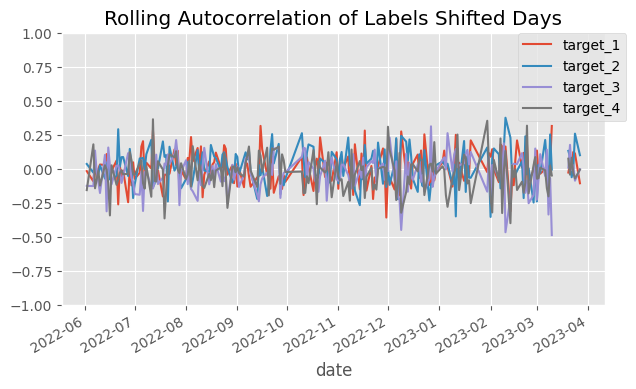

In [65]:
all_factors.reset_index(inplace=True)
all_factors.set_index(['date','ts_code'],inplace=True)
tmp = all_factors.loc[all_factors['trade_date']>20220601]
ph.IID_check(tmp)

### Train/Valid/Test Splits
Split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [66]:
features = ['turnover_rate', 'total_mv', 'atr_5', 'pe', 'pb', 'revenue_ps', 
       'dt_eps_yoy', 'bps_yoy', 'roe_yoy', 'ebt_yoy', 'or_yoy', 'equity_yoy',
       'alpha_cci', 'alpha_supertrend', 'alpha_kama', 'alpha_close2open_5_sma',
       'alpha_close2open_25_sma', 'alpha_skew2sentiment', 'alpha_fundamental']+ sector_columns

target_label = 'target'

for col in features:
    if all_factors[col].isnull().any():
        print(col)
        
if all_factors[target_label].isnull().any():
    print(target_label)
all_factors = all_factors.fillna(0.)
#all_factors.head()
all_factors.sort_index(inplace=True)

alpha_skew2sentiment


In [67]:
#all_factors = all_factors[~all_factors.isin([np.nan, np.inf, -np.inf]).any(1)]
all_factors = all_factors.replace([np.inf, -np.inf], 0.)
all_factors.shape

(431456, 85)

In [68]:
tmp = all_factors.dropna().copy()
X = tmp[features]
y = tmp[target_label]

X_train, X_valid, X_test, y_train, y_valid, y_test = ph.train_valid_test_split(X, y, 0.6, 0.2, 0.2)

X_test.head()

turnover_rate      total_mv     atr_5         pe  \
date       ts_code                                                       
2022-01-21 000028.SZ         0.7885  1.501441e+06  0.818962    10.7101   
           000034.SZ         6.5957  1.245909e+06  1.044444    19.9635   
           000150.SZ         2.5522  2.791078e+05  0.154968  1000.0000   
           000411.SZ         3.2256  3.639110e+05  0.639664    23.2163   
           000423.SZ         1.4563  2.546106e+06  1.953110   588.1612   

                           pb  revenue_ps  dt_eps_yoy   bps_yoy    roe_yoy  \
date       ts_code                                                           
2022-01-21 000028.SZ   1.0228    117.2783      7.7253    5.2416    -0.5787   
           000034.SZ   2.4372    130.1736    -88.1753   25.1544   -91.1619   
           000150.SZ  37.4877      1.1614     -8.5835 -165.0386  -976.6652   
           000411.SZ   2.0043     80.0085      9.5630    6.9867     1.4154   
           000423.SZ   2.5890      4.3208   1537.2308    1.0592  1510.7315   

                        ebt_yoy  ...  alpha_close2open_5_sma  \
date       ts_code               ...                           
2022-01-21 000028.SZ     5.3180  ...               -0.396589   
           000034.SZ   -61.9622  ...                1.068043   
           000150.SZ    -3.2776  ...                0.682847   
           000411.SZ    15.0107  ...                0.088595   
           000423.SZ  6325.6769  ...                0.309430   

                      alpha_close2open_25_sma  alpha_skew2sentiment  \
date       ts_code                                                    
2022-01-21 000028.SZ                -2.103786              0.639793   
           000034.SZ                 1.078280             -0.858802   
           000150.SZ                -0.483556              0.298776   
           000411.SZ                -1.799854              0.942003   
           000423.SZ                 0.665676              0.142152   

                      alpha_fundamental  sector_1  sector_2  sector_3  \
date       ts_code                                                      
2022-01-21 000028.SZ          -3.403307     False      True     False   
           000034.SZ          -0.489860     False     False     False   
           000150.SZ          -0.001960     False     False     False   
           000411.SZ          -0.123802     False      True     False   
           000423.SZ           0.000000     False     False      True   

                      sector_4  sector_5  sector_6  
date       ts_code                                  
2022-01-21 000028.SZ     False     False     False  
           000034.SZ     False     False      True  
           000150.SZ      True     False     False  
           000411.SZ     False     False     False  
           000423.SZ     False     False     False  

[5 rows x 25 columns]

### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [14]:
n_days = 10
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}
n_trees_l = [50, 100, 200]

### Pick Important Features by Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier


train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|█████████████████████████| 4/4 [02:06<00:00, 31.67s/Model]


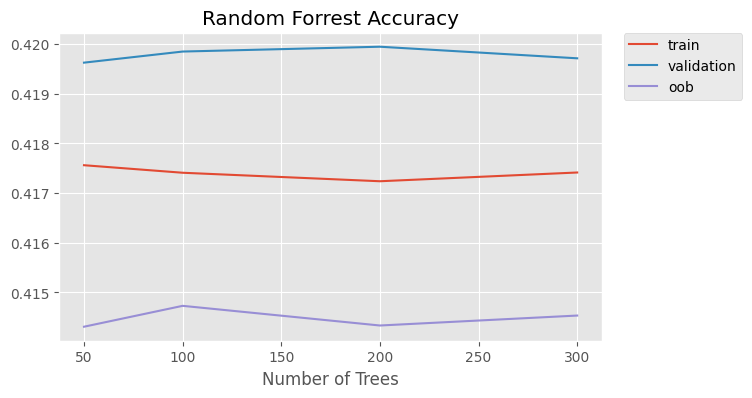

Features Ranked by Average Importance:

      Feature                     Importance
 1. turnover_rate           (0.38801402041773103)
 2. atr_5                   (0.19485580109749115)
 3. alpha_fundamental       (0.12029509854835178)
 4. pe                      (0.07907022274434874)
 5. alpha_cci               (0.04259372823635582)
 6. pb                      (0.038139224060575225)
 7. sector_3                (0.02298067219858605)
 8. total_mv                (0.02128091062537167)
 9. sector_6                (0.01633952273354374)
10. alpha_kama              (0.012660142368387597)
11. sector_5                (0.010953385475943355)
12. equity_yoy              (0.01027865169147851)
13. ebt_yoy                 (0.006647053254823202)
14. revenue_ps              (0.005678548343615271)
15. alpha_supertrend        (0.005360181362634815)
16. dt_eps_yoy              (0.0052267181450511655)
17. alpha_close2open_5_sma  (0.005044856018284095)
18. roe_yoy                 (0.0037495155797846987)
19. 

In [20]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')
print('Features Ranked by Average Importance:\n')
ph.rank_features_by_importance(np.average(feature_importances, axis=0), features)

#### Results
Let's compare our AI Alpha factor to a few other factors. We'll use the following:

In [15]:
factor_names = [
    'alpha_fundamental',
    'alpha_cci',
    'alpha_kama',
    'alpha_close2open_5_sma',
    'alpha_close2open_25_sma',
    'alpha_supertrend',
    'alpha_skew2sentiment',
    'turnover_rate',
    'atr_5'
]

#all_pricing = all_factors.reset_index().pivot(index='date', columns='ts_code', values='close')
#all_pricing.head()

tmp = all_factors.copy(deep=True)
tmp['close'] = all_factors.groupby('ts_code')['close'].shift(-5).fillna(method='ffill')
tmp.loc[tmp.index.get_level_values(1) == '603538.SH']['close']
all_pricing = tmp.reset_index().pivot(index='date', columns='ts_code', values='close')
all_pricing.head()

ts_code,000028.SZ,000034.SZ,000150.SZ,000153.SZ,000411.SZ,000423.SZ,000513.SZ,000555.SZ,000597.SZ,000623.SZ,...,688619.SH,688639.SH,688656.SH,688658.SH,688670.SH,688687.SH,688739.SH,688777.SH,688787.SH,688799.SH
date,,,,,,,,,,,,,,,,,,,,,
2017-06-02,71.68929,NaN,12.84337,NaN,17.46547,62.71696,25.03785,NaN,NaN,20.87682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-05,72.13503,NaN,12.83833,NaN,17.94838,65.02873,25.76079,NaN,NaN,20.59365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-06,72.70148,NaN,12.84337,NaN,17.80351,65.48202,25.61467,NaN,NaN,20.83435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-07,71.44785,NaN,12.82320,NaN,17.54595,64.04963,25.21089,NaN,NaN,20.83435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-08,71.49428,NaN,12.82825,NaN,17.51376,62.80762,25.15706,NaN,NaN,20.77771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch

class NoOverlapVoter(VotingClassifier):
    
    def _calculate_oob_score(self, classifiers):
        oob = 0
        for clf in classifiers:
            oob = oob + clf.oob_score_
        return oob / len(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        estimators_ = []
        for i in range(n_skip_samples):
            estimators_.append(
                classifiers[i].fit(x[i::n_skip_samples], y[i::n_skip_samples])
            )
        return estimators_
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting=voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

### Train Model

In [18]:
n_days = 2
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}
n_trees_l = [100, 150, 250]

train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|█████████████████████████| 3/3 [01:49<00:00, 36.52s/Model]


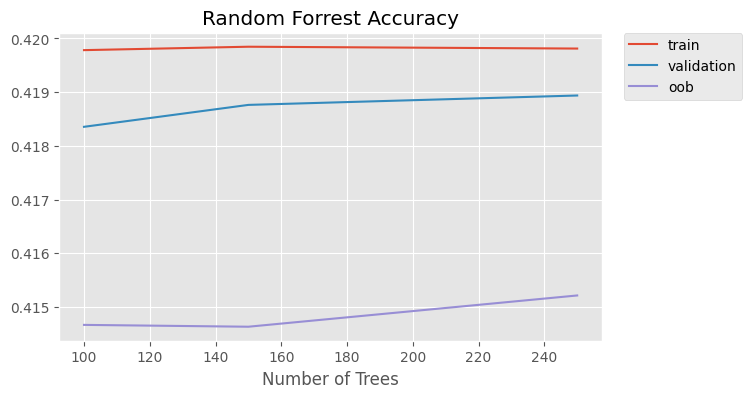

In [19]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

### Evalueate alpha factor

In [20]:
import alphalens as al

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1, 0, 1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = ph.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = ph.get_factor_returns(factor_data)
    sharpe_ratio = ph.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    ph.plot_factor_returns(factor_returns)
    ph.plot_factor_rank_autocorrelation(factor_data)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

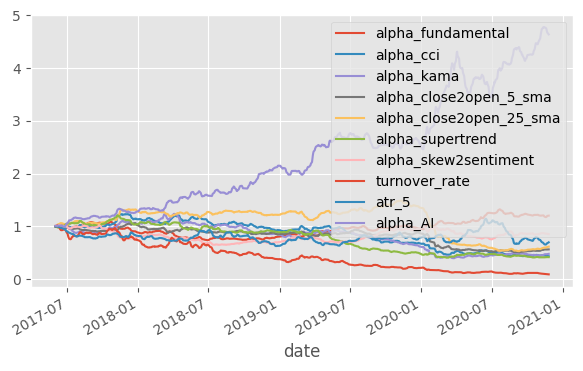

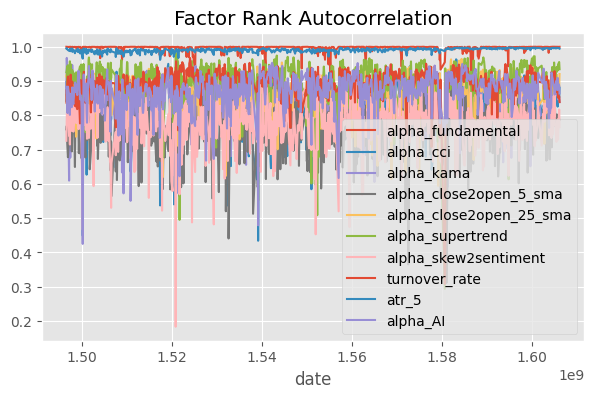

In [21]:
show_sample_results(all_factors, X_train, clf_nov, factor_names, pricing=all_pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

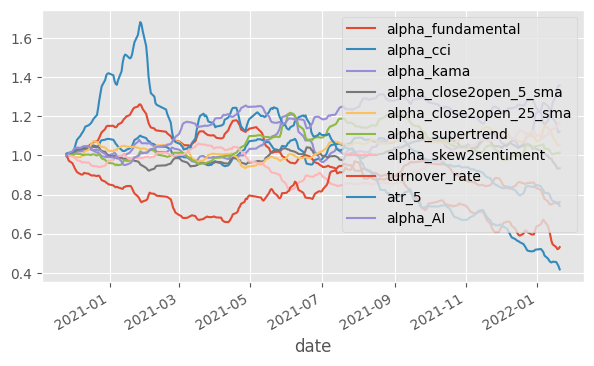

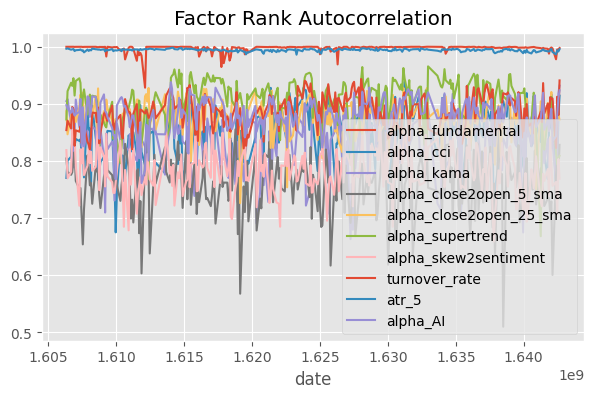

In [22]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names, pricing=all_pricing)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [29]:
n_days = 3
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees = 250

train_score = []
valid_score = []
oob_score = []

clf = RandomForestClassifier(n_trees, **clf_parameters)
    
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

train_score.append(clf_nov.score(X_train, y_train.values))
valid_score.append(clf_nov.score(X_valid, y_valid.values))
oob_score.append(clf_nov.oob_score_)

In [30]:
print(train_score)
print(valid_score, oob_score)

[0.41121408485144884]
[0.4225713369669766] [0.41423282644790677]


### View Train Set Results

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

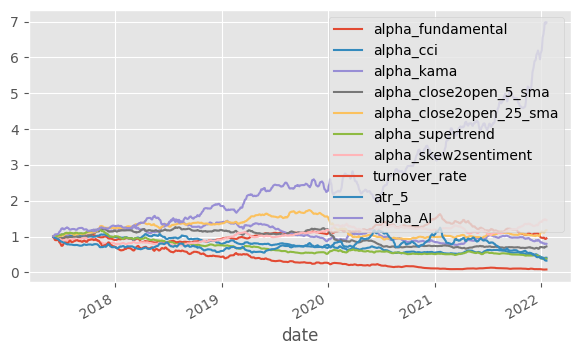

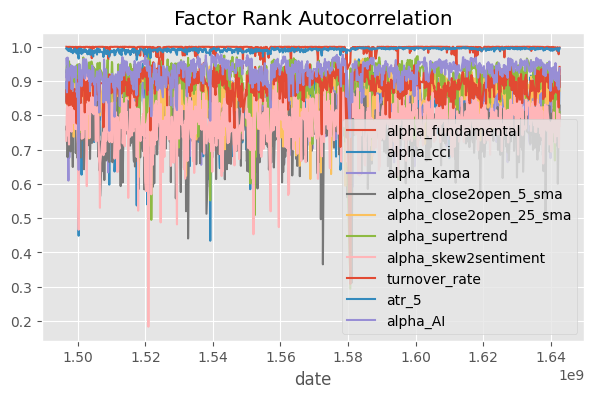

In [37]:
show_sample_results(all_factors, pd.concat([X_train, X_valid]), clf_nov, factor_names, pricing=all_pricing)

### View Test Set Results

Cleaning Data...

Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

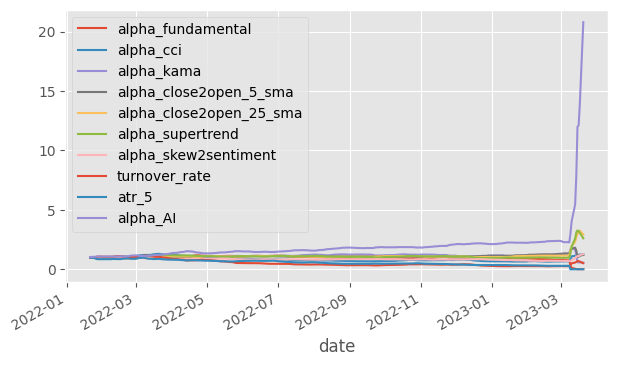

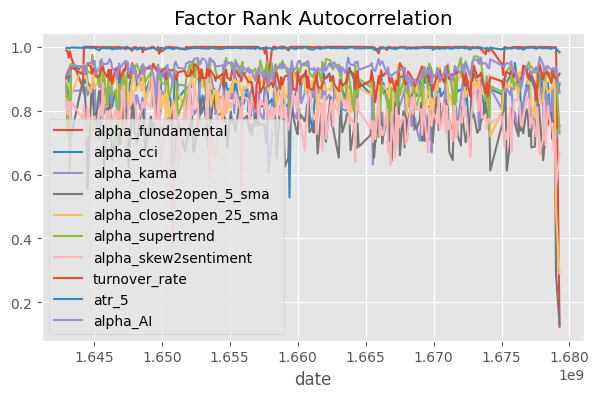

In [38]:
tmp = all_factors.copy(deep=True)
tmp['close'] = all_factors.groupby('ts_code')['close'].shift(-2).fillna(method='ffill')
tmp.loc[tmp.index.get_level_values(1) == '603538.SH']['close']
all_pricing = tmp.reset_index().pivot(index='date', columns='ts_code', values='close')
all_pricing.head()
show_sample_results(all_factors, X_test, clf_nov, factor_names, pricing=all_pricing)

### Merage AI factors

In [69]:
# shift data
#all_factors = universe.copy(deep=True)
# predict 2days
#all_factors['alpha_cci'] = all_factors.groupby('ts_code')['alpha_cci'].shift(2)
#all_factors['alpha_fundamental'] = all_factors.groupby('ts_code')['alpha_fundamental'].shift(5)
#all_factors = all_factors.fillna(method='bfill')
all_factors = all_factors.reset_index().set_index(['date', 'ts_code'])

In [70]:
def save_AI_factors(data, classifier):
    # Calculate the Alpha Score
    samples = data[features]
    prob_array=[-1,0,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))

    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    print(alpha_score, len(alpha_score))
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    return factors_with_alpha
    
all_factors = save_AI_factors(all_factors, clf_nov)
all_factors = all_factors.reset_index().set_index(['date'])
all_factors = universe.merge(all_factors[['alpha_AI','ts_code','trade_date']], on=['ts_code','trade_date'], how='left')

[-0.03963201 -0.02206108 -0.02586456 ... -0.03007899 -0.02537747
 -0.00978476] 431456


In [71]:
field = ['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret', 'return_2q', 
       'alpha_close2open', 'alpha_close2open_5_sma', 'alpha_close2open_25_sma', 
       'alpha_supertrend', 'alpha_cci', 'close_2_kama', 'alpha_kama', 'alpha_skew2sentiment',
       'alpha_fundamental','alpha_AI']
all_factors[field].to_csv('factors_AI_20170405_20230317.csv')

In [33]:
tmp = all_factors[field]
#tmp = tmp.loc[tmp.industry=='化学制药']
tmp = tmp.loc[tmp['trade_D']]
tmp.to_csv('factor_tmp.csv')